<a href="https://colab.research.google.com/github/Rajarshi-Misra/WaveletU-Net/blob/main/WaveletUNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import necessary libraries here itself

In [ ]:
import keras
from keras import layers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import torch
import urllib.request as req
import os
from astropy.io import fits

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

Downloading 20 fits files

In [ ]:
# Mount Google Drive files 
from google.colab import drive
drive.mount('/content/gdrive')

# Upload the kaggle.json file
from google.colab import files
files.upload()

# Install kaggle API client
!pip install -q kaggle

# kaggle API client expects the file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# set permissions
!chmod 600 /root/.kaggle/kaggle.json

# download the required dataset from kaggle
!kaggle datasets download -d redwankarimsony/top-100-hubble-telescope-images



Mounted at /content/gdrive


Saving kaggle.json to kaggle.json
100% 4.88G/4.88G [00:43<00:00, 146MB/s]
100% 4.88G/4.88G [00:43<00:00, 119MB/s]


In [ ]:
# unzip
!unzip top-100-hubble-telescope-images -d ./data

Archive:  top-100-hubble-telescope-images.zip
  inflating: ./data/heic0108a.tif    
  inflating: ./data/heic0109a.tif    
  inflating: ./data/heic0206a.tif    
  inflating: ./data/heic0206b.tif    
  inflating: ./data/heic0206c.tif    
  inflating: ./data/heic0406a.tif    
  inflating: ./data/heic0411a.tif    
  inflating: ./data/heic0503a.tif    
  inflating: ./data/heic0506a.tif    
  inflating: ./data/heic0506b.tif    
  inflating: ./data/heic0514a.tif    
  inflating: ./data/heic0515a.tif    
  inflating: ./data/heic0601a.tif    
  inflating: ./data/heic0602a.tif    
  inflating: ./data/heic0604a.tif    
  inflating: ./data/heic0702a.tif    
  inflating: ./data/heic0706a.tif    
  inflating: ./data/heic0707a.tif    
  inflating: ./data/heic0715a.tif    
  inflating: ./data/heic0719a.tif    
  inflating: ./data/heic0814a.tif    
  inflating: ./data/heic0814b.tif    
  inflating: ./data/heic0817a.tif    
  inflating: ./data/heic0822a.tif    
  inflating: ./data/heic0822b.tif    
  in

(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)
(256, 256)

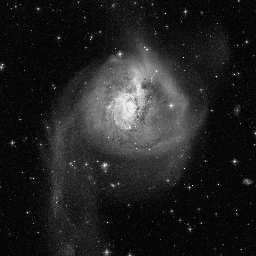

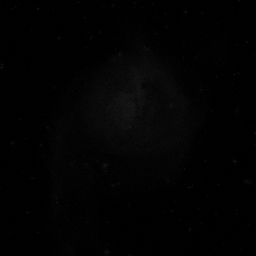

In [ ]:
img = []
img_noise = []
for file in os.listdir("/content/data"):
  image_data = cv2.imread("/content/data/"+file)
  image_data = cv2.cvtColor(image_data, cv2.COLOR_BGR2GRAY)
  # print(image_data.shape)
  # print(image_data.shape[1])
  # print(image_data.shape[0])
  image_data = cv2.resize(image_data, (256,256))
  print(image_data.shape)
  e = 12
  #1. create a sliding window
  #2. Iterate over the image
  DN = np.random.normal(0, np.sqrt(7*e/((60*60)*2)), (256, 256))    
  RON = np.random.normal(0, 3, (256, 256))
  SN = np.random.poisson(np.abs(image_data/2))
  noise_img = (SN + RON + DN)/(e/2)
  noise_img = np.where(image_data == 0.00000000e+00, 0.00000000e+00, noise_img)
  img.append(image_data)
  img_noise.append(noise_img)
cv2_imshow(img[1])
cv2_imshow(img_noise[1])
  #3. Add noise to each window and train.append([arr1,arr2])

In [ ]:
class DWT_downsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x1 = x[:, 0::2, 0::2, :] #x(2i−1, 2j−1)
        x2 = x[:, 1::2, 0::2, :] #x(2i, 2j-1)
        x3 = x[:, 0::2, 1::2, :] #x(2i−1, 2j)
        x4 = x[:, 1::2, 1::2, :] #x(2i, 2j)   

        x_LL = x1 + x2 + x3 + x4
        x_LH = -x1 - x3 + x2 + x4
        x_HL = -x1 + x3 - x2 + x4
        x_HH = x1 - x3 - x2 + x4

        return keras.layers.Concatenate(axis=-1)([x_LL, x_LH, x_HL, x_HH])

In [ ]:
import keras.backend as K

In [ ]:
class IWT_upsampling(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        
    def call(self, x):
        """
        The following calculations for DWT are inspired from,
        https://github.com/AureliePeng/Keras-WaveletTransform/blob/master/models/DWT.py
        """
        x_LL = x[:, :, :, 0:x.shape[3]//4]
        x_LH = x[:, :, :, x.shape[3]//4:x.shape[3]//4*2]
        x_HL = x[:, :, :, x.shape[3]//4*2:x.shape[3]//4*3]
        x_HH = x[:, :, :, x.shape[3]//4*3:]  

        x1 = (x_LL - x_LH - x_HL + x_HH)/4
        x2 = (x_LL - x_LH + x_HL - x_HH)/4
        x3 = (x_LL + x_LH - x_HL - x_HH)/4
        x4 = (x_LL + x_LH + x_HL + x_HH)/4 
        y1 = K.stack([x1,x3], axis=2)
        y2 = K.stack([x2,x4], axis=2)
        shape = K.shape(x)
        return K.reshape(K.concatenate([y1,y2], axis=-1), K.stack([shape[0], shape[1]*2, shape[2]*2, shape[3]//4]))

In [ ]:
input_img = keras.Input(shape = (256, 256, 1))

In [ ]:
x1 = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(input_img)
x1 = layers.Conv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x1)

x2 = DWT_downsampling()(x1)
x2 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x2)
x2 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x2)

x3 = DWT_downsampling()(x2)
x3 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x3)
x3 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x3)

x4 = DWT_downsampling()(x3)
x4 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x4)
x4 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x4)

x5 = DWT_downsampling()(x4)
x5 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x5)
x5 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x5)

x6 = DWT_downsampling()(x5)
x6 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x6)
x6 = layers.Conv2D(filters = 48, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x6)
x = IWT_upsampling()(x6)
x = layers.concatenate([x,x5])
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = IWT_upsampling()(x)
x = layers.concatenate([x,x4])
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = IWT_upsampling()(x)
x = layers.concatenate([x,x3])
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = IWT_upsampling()(x)
x = layers.concatenate([x,x2])
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = IWT_upsampling()(x)
x = layers.concatenate([x,x1])
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 96, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)
x = layers.Conv2D(filters = 1, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x)

Network

In [ ]:
U_Net = keras.Model(input_img, x)

In [ ]:
U_Net.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  320         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

In [ ]:
U_Net.compile(optimizer='adam', loss='mean_squared_error')

In [ ]:
tf_train_noise = np.array(img_noise[0:80])
tf_train_noise.shape

(80, 256, 256)

In [ ]:
tf_train = np.array(img[0:80])
tf_train.shape

(80, 256, 256)

In [ ]:
validation_split = 0.2
history = U_Net.fit(tf_train_noise,tf_train, epochs = 100, batch_size = 20, shuffle = True, validation_split = validation_split)

Epoch 1/100
4/4 [==============================] - 221s 49s/step - loss: 5166.2021 - val_loss: 5818.8340
Epoch 2/100
4/4 [==============================] - 207s 49s/step - loss: 3428.0852 - val_loss: 2562.9202
Epoch 3/100
4/4 [==============================] - 216s 52s/step - loss: 3205.5671 - val_loss: 1921.3215
Epoch 4/100
4/4 [==============================] - 203s 47s/step - loss: 1762.6427 - val_loss: 159.2366
Epoch 5/100
4/4 [==============================] - 205s 48s/step - loss: 633.0494 - val_loss: 559.5690
Epoch 6/100
4/4 [==============================] - 232s 58s/step - loss: 492.7803 - val_loss: 235.5820
Epoch 7/100
4/4 [==============================] - 208s 49s/step - loss: 434.3694 - val_loss: 286.9387
Epoch 8/100
4/4 [==============================] - 216s 52s/step - loss: 375.7807 - val_loss: 143.7051
Epoch 9/100
4/4 [==============================] - 220s 53s/step - loss: 282.9605 - val_loss: 211.2101
Epoch 10/100
4/4 [==============================] - 216s 52s/step 

In [ ]:
history.history.keys()

dict_keys(['loss', 'val_loss'])

In [ ]:
train_loss = history.history['loss']
train_val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

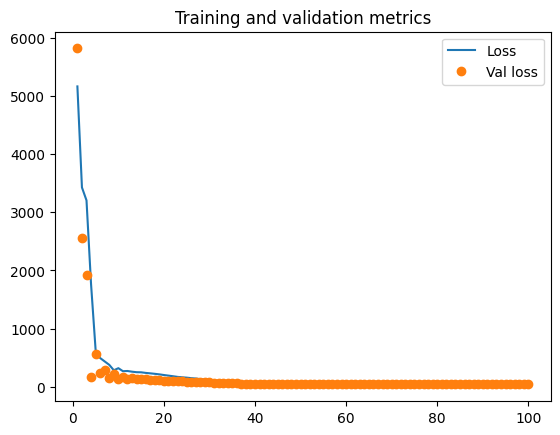

In [ ]:
plt.figure(dpi = 100)
plt.plot(epochs, train_loss, label = 'Loss')
plt.plot(epochs, train_val_loss, 'o', label = 'Val loss')
plt.title('Training and validation metrics')
plt.legend()
plt.savefig('history.png')

In [ ]:
all_denoised_images = U_Net.predict(np.array(img_noise[81:99]))

1/1 [==============================] - 15s 15s/step


In [ ]:
test_loss  = U_Net.evaluate(np.array(img_noise[0:99]), np.array(img[0:99]), batch_size = 20)
print(test_loss)

5/5 [==============================] - 75s 15s/step - loss: 47.3156
47.315643310546875


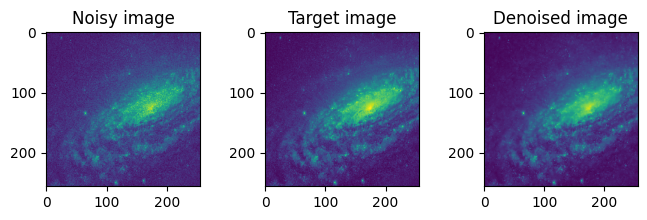

In [ ]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(8, 2)
axes[0].set_title('Noisy image')
im0 = axes[0].imshow(img_noise[83].reshape(256, 256))
axes[1].set_title('Target image')
im1 = axes[1].imshow(img[83].reshape(256, 256))
axes[2].set_title('Denoised image')
im2 = axes[2].imshow(all_denoised_images[2].reshape(256, 256))
plt.savefig(f'comparison.png')